## Importing

In [1]:
## %cd /Users/bezdek/Box/DCL_ARCHIVE/Documents/Events/exp148_Corpus/viz

import pickle as pkl
import pandas as pd
import numpy as np

# For panel visualizations:
import panel as pn
#import param
# For displaying images:
import cv2
from IPython.display import clear_output, Image, display, HTML
from scipy.spatial.distance import cosine
from scipy.ndimage import gaussian_filter1d
from glob import glob
import os
import sys
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from copy import deepcopy
#from run_sem_with_features import preprocess_skel
import joblib
from utils import get_point_biserial, get_binned_prediction
from utils import contain_substr

pn.extension()


### Initialize Variables and Widgets

In [2]:

default_run='3.4.9'
default_tag='may_03_no_skel2D_selection'
epoch= '_1'
available_runs = glob(f'output/run_sem/{default_tag}/*inputdf*.pkl')
available_runs = list(set([os.path.basename(r).split('_')[0] for r in available_runs]))
print(available_runs)
available_tags = ['may_03_no_skel2D_selection', 'may_03_use_skel2D_selection', 'may_03_no_skel2d_no_selection']
print(available_tags)

run_select = pn.widgets.Select(name='Select Run', options=available_runs, value=f'{default_run}')
tag_select = pn.widgets.Select(name='Select tag', options=available_tags, value=f'{default_tag}')
multi_run_select = pn.widgets.MultiSelect(name='Select 2 or 3 Runs for Comparison', value=[default_run], options=available_runs)
multi_tag_select = pn.widgets.MultiSelect(name='Select 2 or 3 Tags for Comparison', value=[default_tag], options=available_tags)
collapse_checkbox = pn.widgets.Checkbox(name='Collapse all PEs?')
account_influence = pn.widgets.Checkbox(name='Account for # of Features on Vector?', value=True)


['3.4.2', '3.4.9', '2.2.10']
['may_03_no_skel2D_selection', 'may_03_use_skel2D_selection', 'may_03_no_skel2d_no_selection']


### Define necessary functions for PE

In [3]:

def frame_to_second(pd_series: pd.Series):
    pd_series.index = pd_series.index / 25
    pd_series.rename_axis('second', inplace=True)
    return pd_series
@pn.depends(run_select.param.value, tag_select.param.value, collapse_checkbox.param.value, account_influence.param.value)
def characterize_pe(run_select, tag_select, fig=None, axes=None, collapse_checkbox=False, account_influence=False):
    if fig is None:
        fig, axes = plt.subplots(nrows=3, figsize=(6, 15))
    for i, epoch in enumerate(['_1', '_2', '_4']):
        inputdf = pkl.load(open(f'output/run_sem/{tag_select}/{run_select}_kinect_trim{tag_select}_inputdf{epoch}.pkl', 'rb'))

        appear_df_post = inputdf.appear_post
        optical_df_post = inputdf.optical_post
        skel_df_post = inputdf.skel_post
        objhand_df_post = inputdf.objhand_post
        if 'scene_motion' in tag_select:
            objspeed_df_post = inputdf.objspeed_post

        # Prepare dataframes to plot input skeleton and predicted skeleton
        pred_appear_df = inputdf.x_inferred_inverted.loc[:, appear_df_post.columns]
        pred_optical_df = inputdf.x_inferred_inverted.loc[:, optical_df_post.columns]
        pred_skel_df = inputdf.x_inferred_inverted.loc[:, skel_df_post.columns]
        pred_objhand_df = inputdf.x_inferred_inverted.loc[:, objhand_df_post.columns]
        if 'scene_motion' in tag_select:
            pred_objspeed_df = inputdf.x_inferred_inverted.loc[:, objspeed_df_post.columns]

        pca_appear_df = inputdf.x_train_inverted.loc[:, appear_df_post.columns]
        pca_optical_df = inputdf.x_train_inverted.loc[:, optical_df_post.columns]
        pca_skel_df = inputdf.x_train_inverted.loc[:, skel_df_post.columns]
        pca_objhand_df = inputdf.x_train_inverted.loc[:, objhand_df_post.columns]
        if 'scene_motion' in tag_select:
            pca_objspeed_df = inputdf.x_train_inverted.loc[:, objspeed_df_post.columns]

        # to remove 3D and 2D columns if necessary
        keep = ['acceleration', 'speed', 'dist_from_J1', 'interhand']
        for c in pred_skel_df.columns:
            if contain_substr(c, keeps=keep):
                continue
            else:
                pred_skel_df.drop([c], axis=1, inplace=True)
                pca_skel_df.drop([c], axis=1, inplace=True)
        pe_appear = (pred_appear_df - pca_appear_df)
        pe_optical = (pred_optical_df - pca_optical_df)
        pe_skel = (pred_skel_df - pca_skel_df)
        pe_objhand = (pred_objhand_df - pca_objhand_df)
        if 'scene_motion' in tag_select:
            pe_objspeed = (pred_objspeed_df - pca_objspeed_df)

        if account_influence:
            pe_appear = np.sqrt(np.square(pe_appear).sum(axis=1))
            pe_optical = np.sqrt(np.square(pe_optical).sum(axis=1))
            pe_skel = np.sqrt(np.square(pe_skel).sum(axis=1))
            pe_objhand = np.sqrt(np.square(pe_objhand).sum(axis=1))
            if 'scene_motion' in tag_select:
                pe_objspeed = np.sqrt(np.square(pe_objspeed).sum(axis=1))
        else:
            pe_appear = np.sqrt(np.square(pe_appear).mean(axis=1))
            pe_optical = np.sqrt(np.square(pe_optical).mean(axis=1))
            pe_skel = np.sqrt(np.square(pe_skel).mean(axis=1))
            pe_objhand = np.sqrt(np.square(pe_objhand).mean(axis=1))
            if 'scene_motion' in tag_select:
                pe_objspeed = np.sqrt(np.square(pe_objspeed).mean(axis=1))
            
        
        pe_appear = frame_to_second(pe_appear)
        pe_optical = frame_to_second(pe_optical)
        pe_skel = frame_to_second(pe_skel)
        pe_objhand = frame_to_second(pe_objhand)
        if 'scene_motion' in tag_select:
            pe_objspeed = frame_to_second(pe_objspeed)
        if collapse_checkbox:
            data_frames = [pe_appear, pe_optical, pe_skel, pe_objhand]
            if 'scene_motion' in tag_select:
                data_frames.append(pe_objspeed)
            pe_combined = pd.concat(data_frames, axis=1).mean(axis=1)
            pe_combined.plot(ax=axes[i], label='Combined PE')
        else:
            pe_appear.plot(ax=axes[i], sharey=True, alpha=0.7, label='Appear')
            pe_optical.plot(ax=axes[i], sharey=True, alpha=0.7, label='Optical')
            pe_skel.plot(ax=axes[i], sharey=True, alpha=0.7, label='Skel')
            pe_objhand.plot(ax=axes[i], sharey=True, alpha=0.7, label='Objhand')
            if 'scene_motion' in tag_select:
               pe_objspeed.plot(ax=axes[i], sharey=True, alpha=0.7, label='Objspeed')
        axes[i].legend()
        axes[i].set_ylabel('Averaged Prediction Error')
        axes[i].set_title(f'{run_select}_{tag_select}_{epoch}.png')

    return fig

@pn.depends(multi_run_select.param.value, tag_select.param.value, collapse_checkbox.param.value, account_influence.param.value)
def multi_runs_across_epochs(multi_run_select, tag_select, collapse_checkbox, account_influence):
    if len(multi_run_select) > 1:
        fig, axes = plt.subplots(ncols=len(multi_run_select), nrows=3, figsize=(6*len(multi_run_select), 15), sharey='all')
        for i, run in enumerate(multi_run_select):
            characterize_pe(run_select=run, tag_select=tag_select, fig=fig, axes=axes[:, i], collapse_checkbox=collapse_checkbox, account_influence=account_influence)
        return fig
    else:
        fig = characterize_pe(run_select=multi_run_select[0], tag_select=tag_select, collapse_checkbox=collapse_checkbox, account_influence=account_influence)
        return fig

@pn.depends(multi_tag_select.param.value, run_select.param.value, collapse_checkbox.param.value, account_influence.param.value)
def multi_tags_across_epochs(multi_tag_select, run_select, collapse_checkbox, account_influence):
    if len(multi_tag_select) > 1:
        fig, axes = plt.subplots(nrows=len(multi_tag_select), ncols=3, figsize=(15, 5*len(multi_tag_select)), sharey='all')
        for i, tag in enumerate(multi_tag_select):
            characterize_pe(run_select=run_select, tag_select=tag, fig=fig, axes=axes[i, :], collapse_checkbox=collapse_checkbox, account_influence=account_influence)

    else:
        fig = characterize_pe(run_select=run_select, tag_select=multi_tag_select[0], collapse_checkbox=collapse_checkbox, account_influence=account_influence)
    
    fig.savefig(f'{run_select}_PE_across_tags.png')
    return fig

# characterize_pe(run_select=default_run, tag_select=default_tag)

### Compare PE across epochs

Column
    [0] Row
        [0] Markdown(str)
    [1] Row
        [0] MultiSelect(name='Select 2 or 3..., options=['3.4.2', '3.4.9', ...], value=['3.4.9'])
        [1] Select(options=['may_03_no_skel2D_selecti...], value='may_03_no_skel2D_selectio...)
        [2] Column
            [0] Checkbox(name='Collapse all PEs?')
            [1] Checkbox(name='Account for #..., value=True)
    [2] ParamFunction(function)
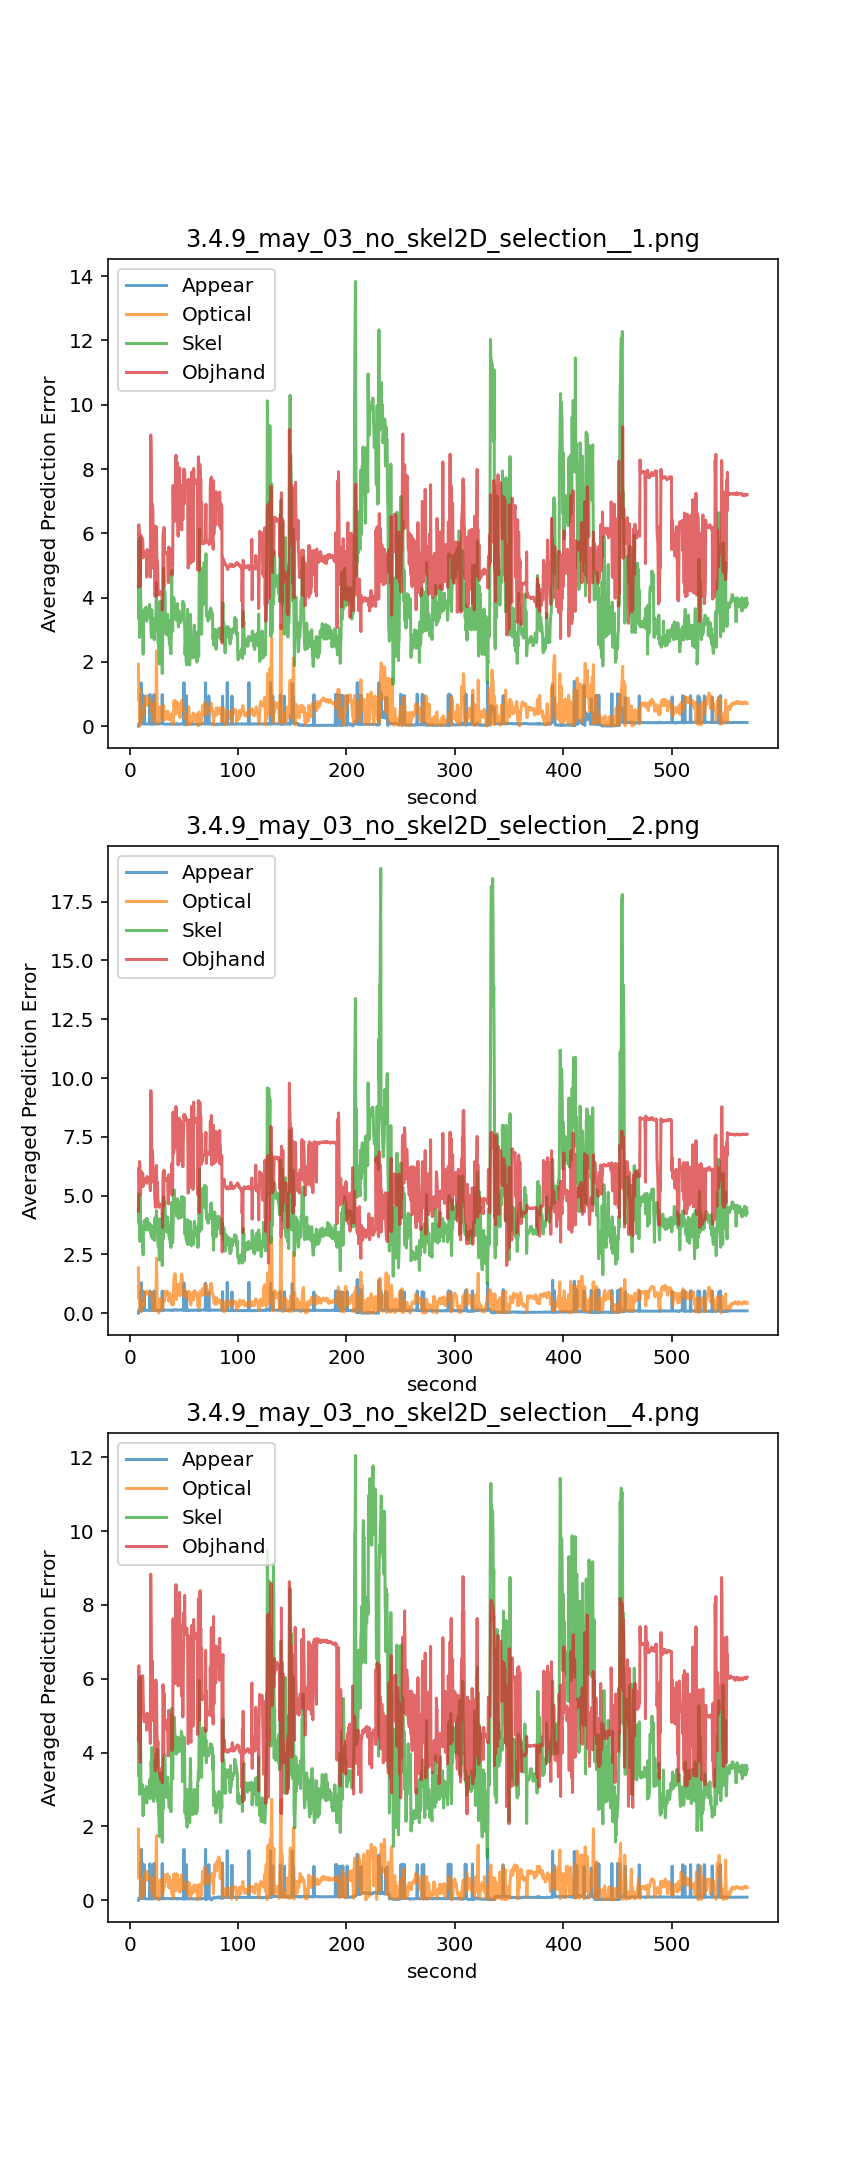

In [4]:
dashboard = pn.Column(
    pn.Row('Compare PE across Epochs'),
    pn.Row(multi_run_select, tag_select, pn.Column(collapse_checkbox, account_influence)), 
    multi_runs_across_epochs
)

# Launch the dashboard
dashboard.servable()

### Compare PE across models

Column
    [0] Row
        [0] Markdown(str)
    [1] Row
        [0] MultiSelect(name='Select 2 or 3..., options=['may_03_no_skel2D_selecti...], value=['may_03_no_skel2D_selecti...])
        [1] Select(options=['3.4.2', '3.4.9', ...], value='3.4.9')
        [2] Column
            [0] Checkbox(name='Collapse all PEs?')
            [1] Checkbox(name='Account for #..., value=True)
    [2] ParamFunction(function)
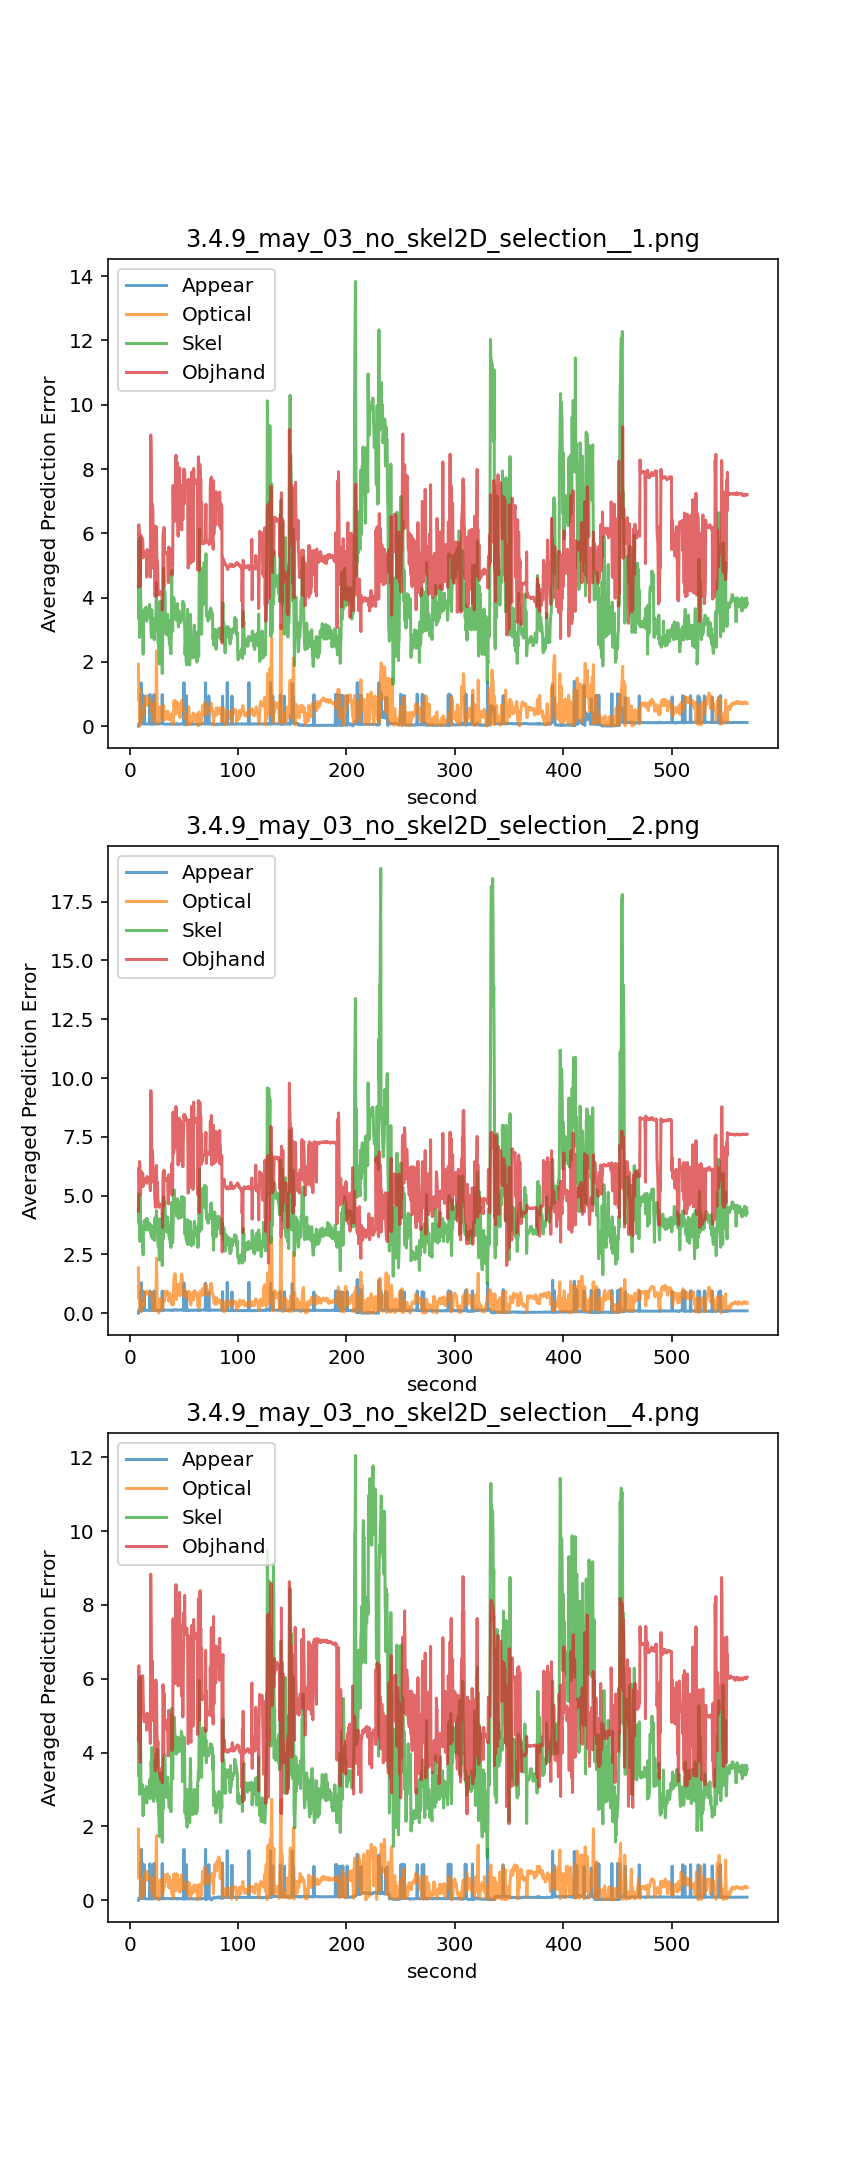

In [5]:
dashboard = pn.Column(
    pn.Row('Compare PE across Models'),
    pn.Row(multi_tag_select, run_select, pn.Column(collapse_checkbox, account_influence)), 
    multi_tags_across_epochs
)

# Launch the dashboard
dashboard.servable()

